In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
import lightkurve as lk
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS
import fitsio
from tqdm import tqdm

from astroquery.jplhorizons import Horizons
from sbident import SBIdent

from tess_ephem import ephem, TessEphem, log
from tess_asteroid_ml import *
from tess_asteroid_ml.utils import *
from ipywidgets import *

In [12]:
sector = 4
camera = 1
ccd = 4
scc_str = f"s{sector:04}-{camera}-{ccd}"
scc_str

path = "/Volumes/ADAP-Kepler/Work/BAERI/data/tess/ffi"
cutout_size = 50

In [13]:
ffi_path = f"{path}/sector{sector:04}/tess2018307065939-{scc_str}-0124-s_ffic.fits"

In [14]:
with fits.open(ffi_path) as ffi:
    wcs = WCS(ffi[1])
    date_obs = Time([ffi[0].header["DATE-OBS"], ffi[0].header["DATE-END"]])

In [15]:
col_2d, row_2d, f2d = load_ffi_image(
                "TESS",
                ffi_path,
                1,
                None,
                [0, 0],
                return_coords=True,
            )
ra_2d, dec_2d = wcs.all_pix2world(np.vstack([col_2d.ravel(), row_2d.ravel()]).T, 0.0).T
ra_2d = ra_2d.reshape(col_2d.shape)
dec_2d = dec_2d.reshape(col_2d.shape)

In [16]:
ffi_coord = SkyCoord(ra_2d*u.deg, dec_2d*u.deg, frame='icrs', obstime=date_obs.mean().isot)

In [19]:
ccd = 0
scc_str = f"s{sector:04}-{camera}-{ccd}"

In [22]:
jpl_sbi_file = f"{os.path.dirname(PACKAGEDIR)}/data/jpl/jpl_small_bodies_tess_{scc_str}_catalog.csv"

if os.path.isfile(jpl_sbi_file):
    print("Loading from CSV file...")
    jpl_sb = pd.read_csv(jpl_sbi_file, index_col=0)

jpl_sb_bright = jpl_sb.query("V_mag <= 18")
jpl_sb_bright

Loading from CSV file...


,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")","Dist. from center RA ("")","Dist. from center Dec ("")","Dist. from center Norm ("")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)",ra,dec,V_mag,name,id
0,23 Thalia (A852 XA),02:17:25.72,+04:42:15.7,-30000.0,30000.0,38000.0,10.4,-42.45,-3.11700,34.357167,4.704361,10.4,23 Thalia,A852 XA
1,46 Hestia (A857 QA),02:06:33.37,+10:07:53.4,-40000.0,50000.0,59000.0,11.0,-36.38,-13.68000,31.639042,10.131500,11.0,46 Hestia,A857 QA
2,307 Nike (A891 EB),01:53:36.72,+01:45:59.6,-50000.0,20000.0,51000.0,13.6,-33.81,-6.22300,28.403000,1.766556,13.6,307 Nike,A891 EB
3,318 Magdalena (A891 SA),01:49:45.16,-01:12:56.6,-50000.0,6000.0,52000.0,14.1,-28.23,-11.98000,27.438167,-1.215722,14.1,318 Magdalena,A891 SA
4,381 Myrrha (A894 AC),03:26:13.42,+01:00:51.5,30000.0,10000.0,37000.0,13.5,-29.41,-8.06500,51.555917,1.014306,13.5,381 Myrrha,A894 AC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6724,361431 (2006 YP18),03:04:27.12,+02:24:20.4,20000.0,20000.0,24000.0,17.8,-47.44,11.82000,46.113000,2.405667,17.8,361431,2006 YP18
6780,363870 (2005 SE25),02:46:37.30,+03:51:56.9,-691.0,20000.0,24000.0,17.9,-29.53,-25.79000,41.655417,3.865806,17.9,363870,2005 SE25
9770,524606 (2003 QT79),03:14:43.71,+05:41:40.3,20000.0,30000.0,39000.0,17.9,-34.95,25.97000,48.682125,5.694528,17.9,524606,2003 QT79
21680,(2018 UR2),03:26:44.56,+06:12:07.1,40000.0,30000.0,48000.0,15.9,-547.70,1111.00000,51.685667,6.201972,15.9,NaN,2018 UR2


In [23]:
sb_ephems_lowres = {}

for k, row in jpl_sb_bright.iterrows():
    
    feath_file = f"{os.path.dirname(PACKAGEDIR)}/data/jpl/tracks/sector{sector:04}/tess-ffi_s0004-0-0_{row['id'].replace(' ', '-')}_hires.feather"
    if os.path.isfile(feath_file):
        sb_ephems_lowres[k] = pd.read_feather(feath_file)

In [26]:
ccd = 4

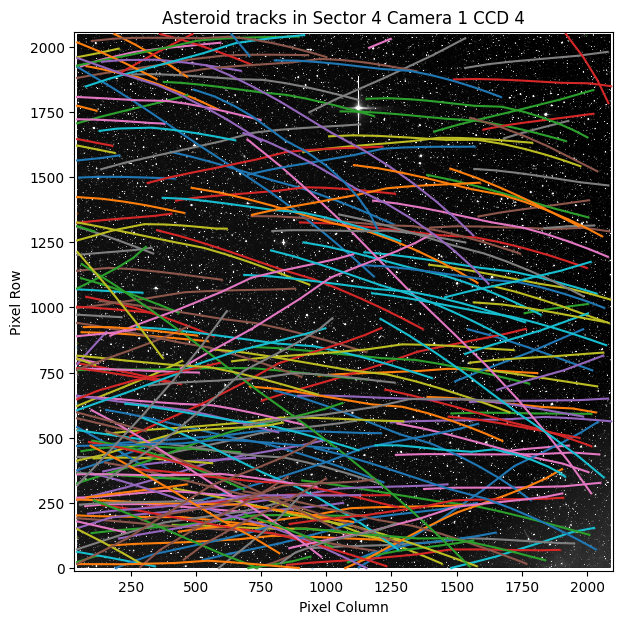

In [30]:
vlo, lo, mid, hi, vhi = np.nanpercentile(f2d, [0.2, 1, 50, 95, 99.8])
cnorm = colors.SymLogNorm(linthresh=mid, vmin=lo, vmax=vhi, base=10)
cnorm = colors.LogNorm(vmin=lo, vmax=vhi)

plt.figure(figsize=(7,7))
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD {ccd}")
plt.pcolormesh(col_2d, row_2d, f2d, norm=cnorm, cmap="Greys_r")

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    val = val.query(f"camera == {camera} and ccd == {ccd}")
    plt.plot(val.column[::100], val.row[::100], ".-", ms=.5)
    # if k == 1: break

plt.xlim(col_2d.min() - 10, col_2d.max() + 10)
plt.ylim(row_2d.min() - 10, row_2d.max() + 10)
plt.gca().set_aspect('equal')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()

In [ ]:
vlo, lo, mid, hi, vhi = np.nanpercentile(f2d, [0.2, 1, 50, 95, 99.8])
cnorm = colors.SymLogNorm(linthresh=mid, vmin=lo, vmax=vhi, base=10)
cnorm = colors.LogNorm(vmin=lo, vmax=vhi)

plt.figure(figsize=(7,7))
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD {ccd}")
plt.pcolormesh(col_2d, row_2d, f2d, norm=cnorm, cmap="Greys_r")

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    val = val.query(f"camera == {camera} and ccd == {ccd}")
    plt.plot(val.column[::100], val.row[::100], ".-", ms=.5)
    # if k == 1: break

plt.xlim(col_2d.min() - 10, col_2d.max() + 10)
plt.ylim(row_2d.min() - 10, row_2d.max() + 10)
plt.gca().set_aspect('equal')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()

In [31]:
sb_ephems_lowres[0]

,time,sector,camera,ccd,column,row,pixels_per_hour,ra,dec,vmag,sun_distance,obs_distance,phase_angle
0,2.458411e+06,4,1,4,155.360952,606.735635,1.790637,38.100323,5.161421,10.612587,2.533602,1.557375,5.821726
1,2.458411e+06,4,1,4,156.259098,606.615989,1.793747,38.095163,5.160414,10.612057,2.533548,1.557251,5.813777
2,2.458411e+06,4,1,4,157.158311,606.494889,1.796762,38.089995,5.159412,10.611521,2.533495,1.557128,5.805826
3,2.458411e+06,4,1,4,158.058571,606.372355,1.799684,38.084819,5.158416,10.610978,2.533442,1.557005,5.797873
4,2.458411e+06,4,1,4,158.959856,606.248404,1.802515,38.079635,5.157426,10.610429,2.533389,1.556882,5.789919
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,2.458437e+06,4,1,4,1258.791930,315.298506,1.375049,31.635577,4.647965,10.629053,2.467408,1.522068,8.552542
1056,2.458437e+06,4,1,4,1259.485198,315.078776,1.372831,31.631571,4.647805,10.629237,2.467355,1.522108,8.560928
1057,2.458437e+06,4,1,4,1260.177423,314.860238,1.370622,31.627572,4.647640,10.629412,2.467301,1.522147,8.569311
1058,2.458437e+06,4,1,4,1260.868603,314.642902,1.368420,31.623581,4.647470,10.629577,2.467248,1.522187,8.577694


In [45]:
track_lengh = []
vmag = []
rate = []

for chip in range(1, 5):
    for k, val in sb_ephems_lowres.items():
        val = val.query(f"camera == {camera} and ccd == {chip}")
        if len(val) == 0:
            continue
        hypot = np.hypot(val.column.values[-1] - val.column.values[0], 
                         val.row.values[-1] - val.row.values[0])
        track_lengh.append(hypot)
        vmag.append(val.vmag.mean())
        rate.append(val.pixels_per_hour.mean())
track_lengh = np.array(track_lengh)
vmag = np.array(vmag)
rate = np.array(rate)

In [53]:
rate.min()

1.1428147802791637

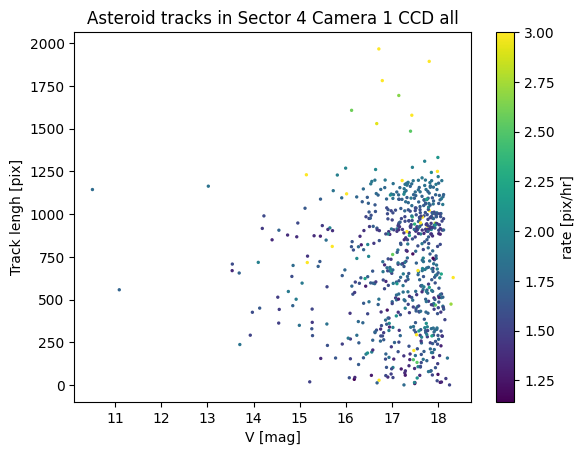

In [54]:
bar = plt.scatter(vmag, track_lengh, c=rate, vmin=rate.min(), vmax=3, s=2, marker="o")
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD all")
plt.colorbar(bar, label="rate [pix/hr]")
plt.xlabel("V [mag]")
plt.ylabel("Track lengh [pix]")
plt.show()